In [24]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.errors import SettingWithCopyWarning
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2, stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import joblib
import os
%matplotlib inline

In [25]:
cc_data_full_data = pd.read_csv('datasets/application_record.csv')
credit_status = pd.read_csv('datasets/credit_record.csv')


In [26]:
cc_data_full_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [27]:
credit_status.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [28]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [29]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning SettingWithCopyWarning

/var/folders/6s/p5n4r24s0z1gc7q41qlwq63r0000gn/T/ipykernel_3520/1467211908.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
/var/folders/6s/p5n4r24s0z1gc7q41qlwq63r0000gn/T/ipykernel_3520/1467211908.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use 

In [32]:
cc_data_full_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Account age,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [33]:
# rename the features to more readable feature names
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

In [34]:
# split the data into train and test dataset
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    # reset the indexes
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [35]:
# we set the test_size to 0.2, which means that the train_size will be 0.8
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)

In [36]:
cc_train_original.shape

(29165, 20)

In [37]:
cc_test_original.shape

(7292, 20)

In [39]:
cc_train_original.to_csv('datasets/train.csv',index=False)

In [41]:
cc_test_original.to_csv('datasets/test.csv',index=False)

In [42]:
# creating a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

In [43]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

In [44]:
cc_data_full_data.describe()

,ID,Children count,Income,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Family member count,Account age
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-26.164193
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,16.501854
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

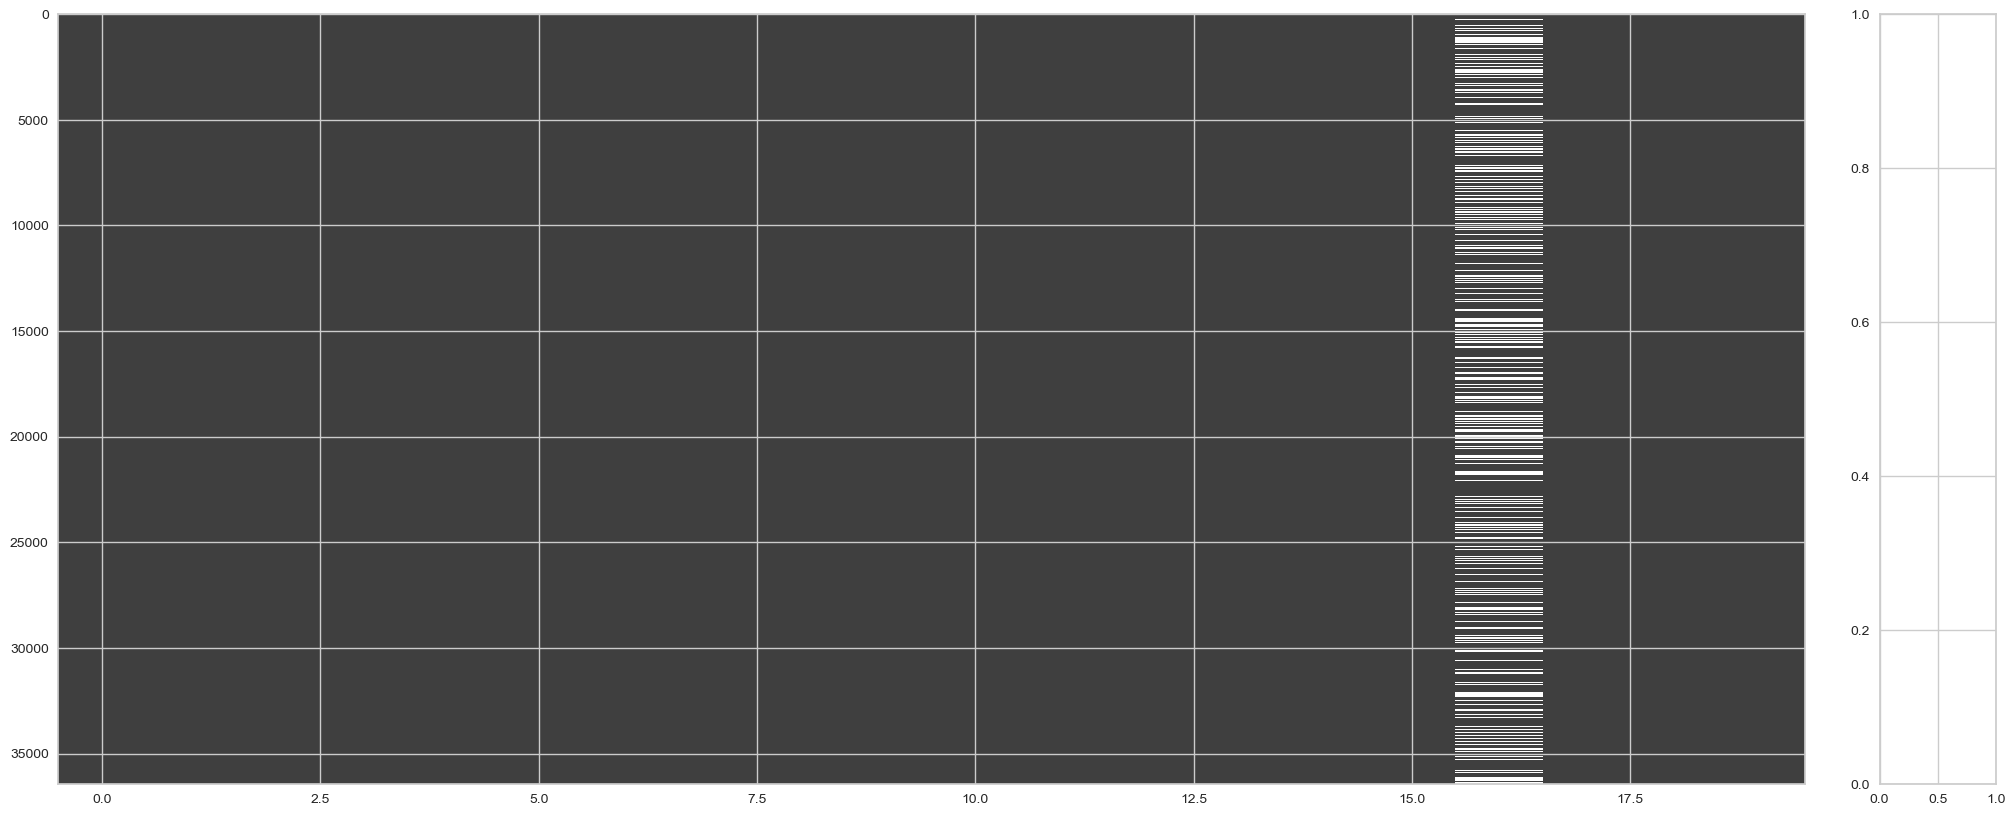

In [45]:
msno.matrix(cc_data_full_data)
plt.show()

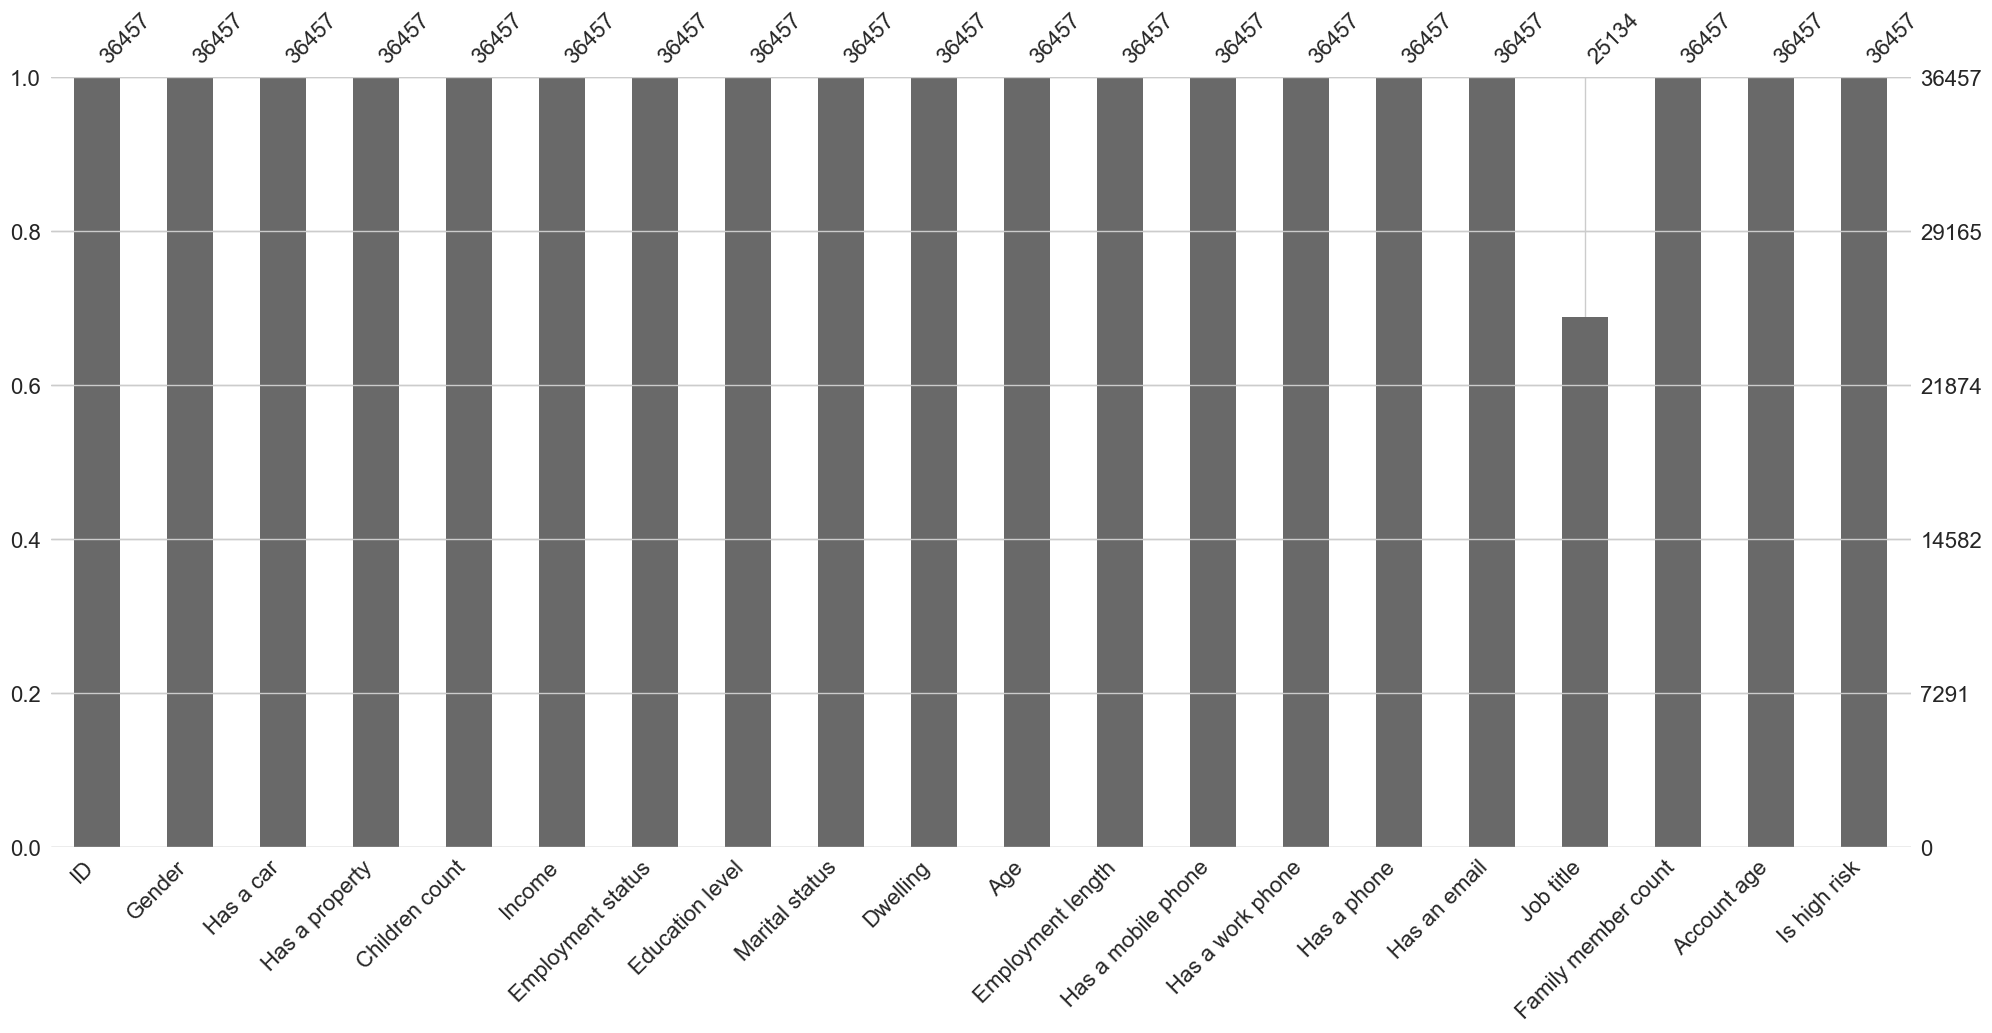

In [46]:
msno.bar(cc_data_full_data)
plt.show()

In [47]:
def value_cnt_norm_cal(df,feature):
    '''Function that will return the value count and frequency of each observation within a feature'''
    # get the value counts of each feature
    ftr_value_cnt = df[feature].value_counts()
    # normalize the value counts on a scale of 100
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    # concatenate the value counts with normalized value count column wise
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    # give it a column name
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    # return the dataframe
    return ftr_value_cnt_concat

In [48]:
def gen_info_feat(df,feature):
    '''function to display general information about the feature'''
    # if the feature is Age
    if feature == 'Age':
        # change the feature to be expressed in positive numbers of days and divide by 365.25 to be expressed in years and get the description
        print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
        # print separators
        print('*'*50)
        # print the datatype
        print('Object type:{}'.format(df[feature].dtype))
    # if the feature is employment length
    if feature == 'Employment length':
        # select only the rows where the rows are negative values to ignore those who have retired or are unemployed
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        # change the negative values to positive values
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        # print the descriptions
        print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
        # print separators
        print('*'*50)
        # print the datatype
        print('Object type:{}'.format(employment_len_no_ret.dtype))
    # if the feature is account age
    if feature == 'Account age' or feature == 'Income':
        # change the account age to a positive number of months and get the description
        print('Description:\n{}'.format((np.abs(df[feature])).describe()))
        # print separators
        print('*'*50)
        # print the datatype
        print('Object type:{}'.format(df[feature].dtype))
    # if it is any other feature
    else:
        # get the description
        print('Description:\n{}'.format(df[feature].describe()))
        # print separators
        print('*'*50)
        # print the datatype
        print('Object type:\n{}'.format(df[feature].dtype))
        # print separators
        print('*'*50)
        # calling the value_cnt_norm_cal function previously seen
        value_cnt = value_cnt_norm_cal(df,feature)
        # print the result
        print('Value count:\n{}'.format(value_cnt))

In [49]:
def create_pie_plot(df,feature):
    '''function to create a pie chart plot'''
    # if the feature is dwelling or education level
    if feature == 'Dwelling' or feature == 'Education level':
        # calling the value_cnt_norm_cal function previously seen
        ratio_size = value_cnt_norm_cal(df, feature)
        # get how many classes we have
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        # loop till the max range
        for i in range(ratio_size_len):
            #append the ratio of each feature to the list
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        # create a subplot
        fig, ax = plt.subplots(figsize=(8,8))
        # %1.2f%% display decimals in the pie chart with 2 decimal places
        plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
        # add a title to the chart
        plt.title('Pie chart of {}'.format(feature))
        # add a legend to the chart
        plt.legend(loc='best',labels=ratio_size.index)
        # center the plot in the subplot
        plt.axis('equal')

        # return the plot
        return plt.show()
    # for other features
    else:
        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        # %1.2f%% display decimals in the pie chart with 2 decimal places
        plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best')
        plt.axis('equal')
        return plt.show()

In [50]:
def create_bar_plot(df,feature):
    '''function to create a bar chart plot'''
    if feature == 'Marital status' or feature == 'Dwelling' or feature == 'Job title' or feature == 'Employment status' or feature == 'Education level':
        fig, ax = plt.subplots(figsize=(6,10))
        # create a barplot using seaborn with X-axis the indexes from value_cnt_norm_cal function and Y axis we use the value counts from the same function
        sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
        # set the plot's tick labels to the index from the value_cnt_norm_cal function, rotate those ticks by 45 degrees
        ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
        # Give the X-axis the same label as the feature name
        plt.xlabel('{}'.format(feature))
        # Give the Y-axis the label "Count"
        plt.ylabel('Count')
        # Give the plot a title
        plt.title('{} count'.format(feature))
        # Return the title
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()

In [51]:
def create_box_plot(df,feature):
    '''function to create a box plot'''
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(2,8))
        # change the feature to be expressed in positive numbers days
        sns.boxplot(y=np.abs(df[feature])/365.25)
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    if feature == 'Children count':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        # use the numpy arrange to populate the Y ticks starting from 0 till the max count of children with an interval of 1 as follows np.arange(start, stop, step)
        plt.yticks(np.arange(0,df[feature].max(),1))
        return plt.show()
    if feature == 'Employment length':
        fig, ax = plt.subplots(figsize=(2,8))
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        # employment length in days is a negative number, so we need to change it to positive and change it to years
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        # create a boxplot with seaborn
        sns.boxplot(y=employment_len_no_ret_yrs)
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
        return plt.show()
    if feature == 'Income':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        # suppress the scientific notation
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        return plt.show()
    if feature == 'Account age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=np.abs(df[feature]))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()

In [52]:
def create_hist_plot(df,feature, the_bins=50):
    '''function to create a histogram plot'''
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(18,10))
        # change the feature to be expressed in positive numbers days
        sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    if feature == 'Income':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(df[feature],bins=the_bins,kde=True)
        # suppress scientific notation
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('{} distribution'.format(feature))
        return plt.show()
    if feature == 'Employment length':
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        # change the feature to be expressed in positive numbers days
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    if feature == 'Account age':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(np.abs(df[feature]),bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(df[feature],bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()

In [54]:
def low_high_risk_box_plot(df,feature):
    '''High risk vs low risk applicants compared on a box plot'''
    if feature == 'Age':
        print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
        fig, ax = plt.subplots(figsize=(5,8))
        # Place on the Y-axis age and X-axis the two box plot (is high risk: No and Yes)
        sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
        # add ticks to the X axis
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by age')
        return plt.show()
    if feature == 'Income':
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        # suppress the scientific notation
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()
    if feature == 'Employment length':
        # checking is an applicant is high risk or not (for those who have negative employment length mean only those who are employed)
        employment_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] <0]
        employment_no_ret_idx = employment_no_ret.index
        employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
        # extract those who are employed from the original dataframe and return only the employment length and Is high risk columns
        employment_no_ret_df = cc_train_copy.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
        # return the mean employment length group by how risky is the applicant
        employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
        print(np.abs(employment_no_ret_is_high_risk)/365.25)
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High vs low risk individuals grouped by {}'.format(feature))
        return plt.show()
    else:
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()

In [55]:
def low_high_risk_bar_plot(df,feature):
    '''High risk vs low risk applicants compared on a bar plot'''
    # get the sum of high-risk clients grouped by a specific feature
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    # sort is a descending order
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    # plot on the X axis the indexes which correspond to classes, and on the Y axis, the count
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    # add the labels to the plot
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

In [56]:
gen_info_feat(cc_train_copy,'Gender')

Description:
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
        Count  Frequency (%)
Gender                      
F       19549      67.028973
M        9616      32.971027


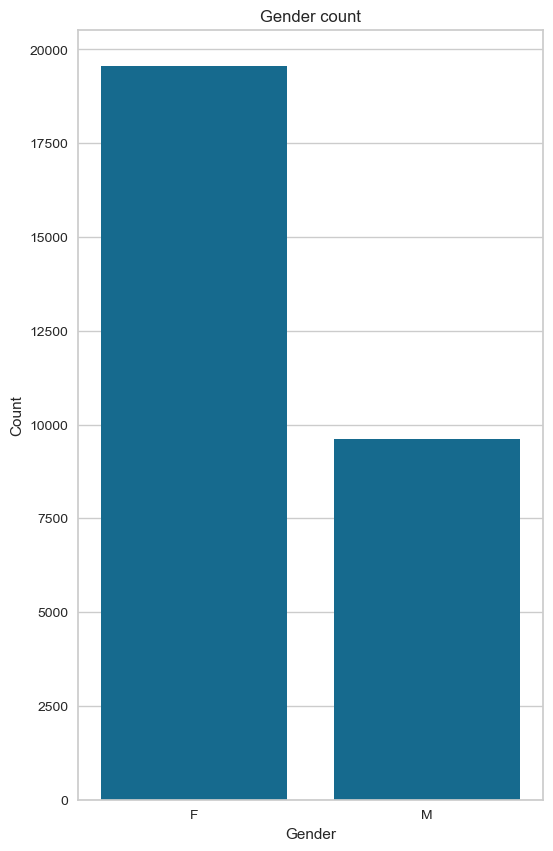

In [57]:
create_bar_plot(cc_train_copy,'Gender')

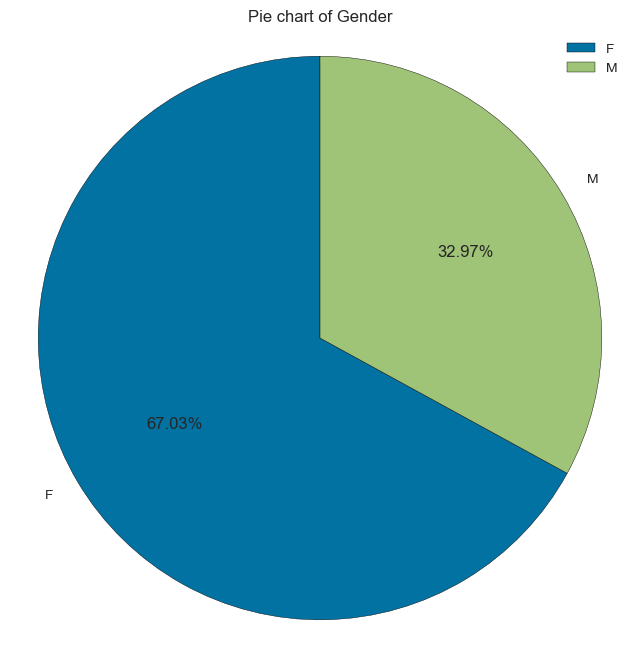

In [58]:
create_pie_plot(cc_train_copy,'Gender')

In [59]:
gen_info_feat(cc_train_copy,'Age')

Description:
count    29165.000000
mean        43.749425
std         11.507180
min         21.095140
25%         34.154689
50%         42.614648
75%         53.234771
max         68.862423
Name: Age, dtype: float64
**************************************************
Object type:int64
Description:
count    29165.000000
mean    -15979.477490
std       4202.997485
min     -25152.000000
25%     -19444.000000
50%     -15565.000000
75%     -12475.000000
max      -7705.000000
Name: Age, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
        Count  Frequency (%)
Age                         
-12676     44       0.150866
-15519     44       0.150866
-16896     33       0.113149
-16053     26       0.089148
-16768     26       0.089148
...       ...            ...
-18253      1       0.003429
-23429      1       0.003429
-15478      1       0.003429
-21648      1       0.003429
-19564      1      

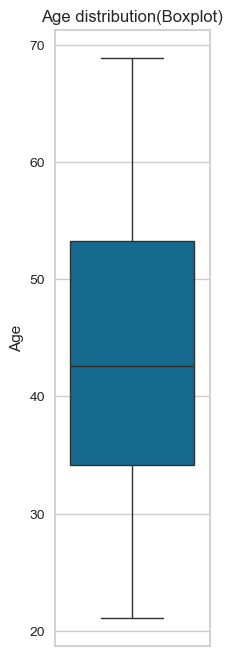

In [60]:
create_box_plot(cc_train_copy,'Age')

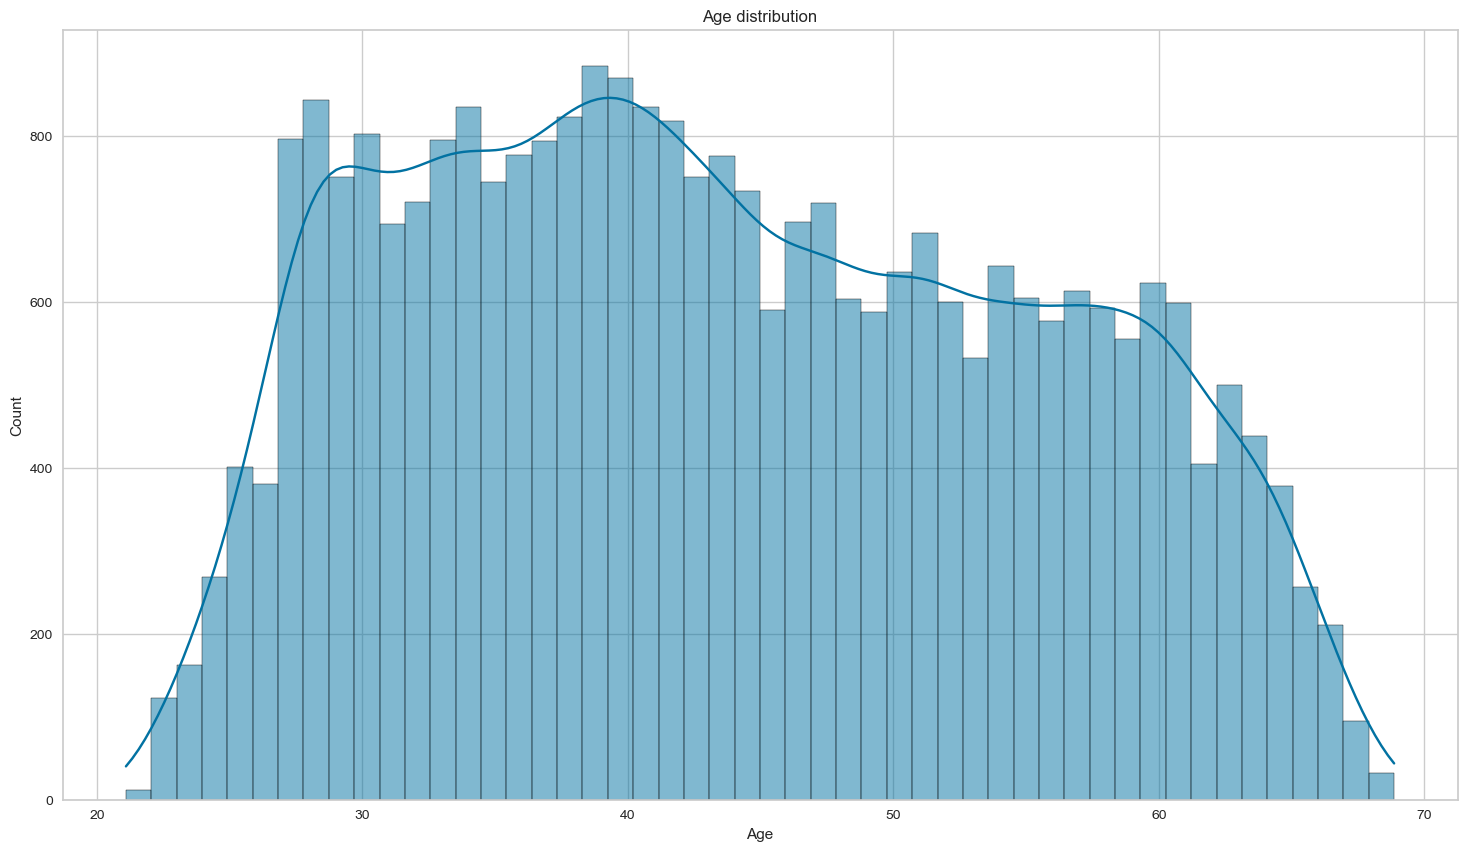

In [61]:
create_hist_plot(cc_train_copy,'Age')

Is high risk
0    43.753103
1    43.538148
Name: Age, dtype: float64


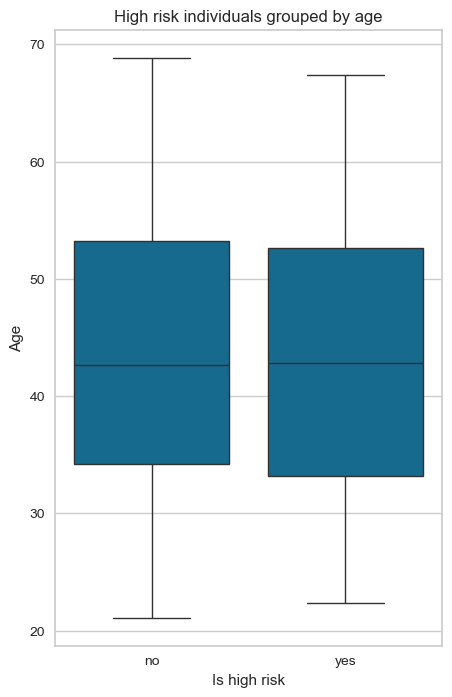

In [62]:
low_high_risk_box_plot(cc_train_copy,'Age')

In [63]:
gen_info_feat(cc_train_copy,'Marital status')

Description:
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Marital status                            
Married               20044      68.726213
Single / not married   3864      13.248757
Civil marriage         2312       7.927310
Separated              1712       5.870050
Widow                  1233       4.227670


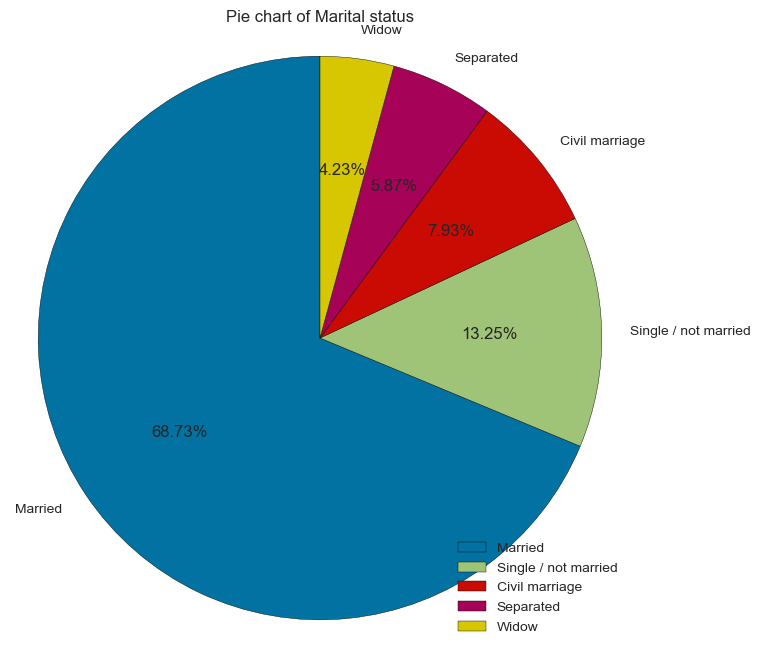

In [64]:
create_pie_plot(cc_train_copy,'Marital status')

/var/folders/6s/p5n4r24s0z1gc7q41qlwq63r0000gn/T/ipykernel_3520/3773336971.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')


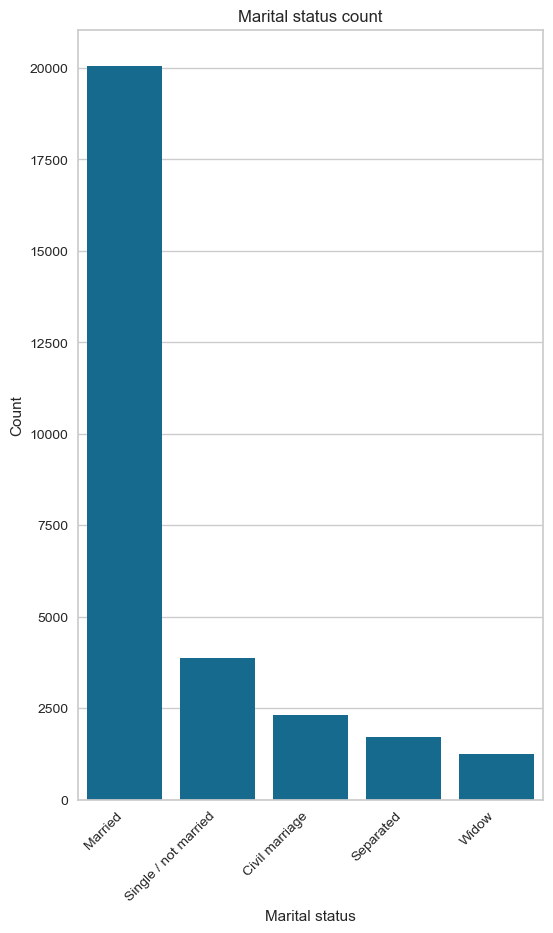

In [65]:
create_bar_plot(cc_train_copy,'Marital status')